<a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![MAIA banner](https://raw.githubusercontent.com/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/main/Images/Aprendizaje_refuerzo_profundo_Banner_V1.png)

# <h1><center>Tarea Tutorial - Semana 2 <a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

<center><h1>Predicción y Control On-Policy</h1></center>

En este notebook tutorial vas a aprender sobre algunas técnicas <i>on-policy</i> que existen para aproximar la función de valor en un problema de aprendizaje por refuerzo y algoritmos de aprendizaje on-policy. Mostraremos el funcionamiento de estas técnica sy algoritmos utilizando el ambiente de <a href="https://gymnasium.farama.org/environments/classic_control/mountain_car/">Mountain Car</a>, incluido en las librerías de Gym, e implementaremos redes nuronales con el framework <a href="https://github.com/inarikami/keras-rl2">keras-rl2</a>, que incluye nuestros algoritmos de interés. La misión central de este notebook es evidenciar de forma visual cómo se puede representar matemáticamente un problema y cómo se estructura una solución cuando se utilizan técnicas <i>on-policy</i>. El tutorial se divide en:


# Tabla de Contenidos
1. [Objetivos de Aprendizaje](#scrollTo=Objetivos_de_Aprendizaje)  
2. [Marco Teórico](#scrollTo=Marco_Te_rico)  
3. [Instalación de Librerías](#scrollTo=Instalaci_n_de_Librer_as)  
4. [Familiarización con el Entorno de Gym](#scrollTo=Familiarizaci_n_con_el_Entorno_de_Gym)  
5. [Predicción on-policy](#scrollTo=Predicci_n_on_policy)  
6. [Control on-policy](#scrollTo=Control_on_policy)  
7. [Reflexiones Finales](#scrollTo=Reflexiones_Finales)  
8. [Referencias](#scrollTo=Referencias)

# Objetivos de Aprendizaje  
  
* Conocer algunas formas matemáticas que se utilizan para representar problemas complejos de aprendizaje por refuerzo.
* Familiarizarse con los entornos de simulación de Gym.
* Entrenar y validar algoritmos de aprendizaje por refuerzo <i>on-policy</i> con redes neuronales (Deep SARSA).



# Marco Teórico  

_-_

_-_

_-_

_-_


Ahora, es necesario redirigir estos conceptos detrás de la aproximación de una función de valor al problema de control de política, es decir, al aprendizaje. Primero, recordemos que en el proceso de control de política un algoritmo busca construir una aproximación de la función de valor de acción $\hat{q}(s,a,\mathbf{w}) \approx q_*(s,a)$, donde $\mathbf{w}$ es un vector de tamaño finito con los pesos que definen la aproximación que se utilice. [1]

Para el caso de tareas episódicas, la extensión de los métodos de predicción de semi-gradiente a las funciones de valor de acciones es directa: $\hat{q}(s,a,\mathbf{w}) \approx q_{\pi}(s,a)$. Después, si se acoplan esas predicciones con técnicas de mejoramiento de política y selección de acciones, obtenemos el control de política. En tareas con un espacio de acciones discreto y relativamente pequeño, para cada posible acción $a$ posible en el siguiente estado $S_{t+1}$, se puede calcular $\hat{q}(S_{t+1},a,\mathbf{w}_t) \approx q_{\pi}(s,a)$ y encontrar la acción <i>greedy</i> ($A^*_{t+1} = \text{arg max}_a
 \hat{q}(s,a,\mathbf{w}))$. Para <i>algoritmos on-policy</i>, la política se mejora cambiando la política de estimación a una aproximación <i>soft</i> (que puede escoger cualquier acción) de la política <i>greedy</i> (que únicamente escoge la mejor acción). [1]

 La siguiente es la regla de actualización de SARSA de un paso, y el pseudoalgoritmo correspondiente se muestra en la Figura 4:



 <center>  $\mathbf{w}_{t+1} = \mathbf{w}_{t+1} + \alpha [R_{t+1} + \gamma \hat{q}(S_{t+1},a,\mathbf{w}_t) - \hat{q}(S_{t+1},a,\mathbf{w}_t) ] \nabla \hat{q}(S_{t+1},a,\mathbf{w}_t)$  &emsp;&emsp;&emsp;$(1)$ </center>


![SARSAnn](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/SARSAnn_dF.png)


<center>Figura 4. Algoritmo de SARSA con aproximación de funciones para control de política.</center>


# Instalación de Librerías  

Ejecute los siguientes bloques de código para instalar e importar las librerías requeridas en el tutorial. Aquí se instalan versiones compatibles de <i>keras</i>, <i>tensorflow</i> y <i>Gymnasium</i> para poder realizar los entrenamientos de SARSA con redes neuronales. La primera ejecución puede demorar un par de minutos en finalizar. Si la segunda celda le da un error, pruebe volver a ejecutar la celda.

In [4]:
#Instala el framework de keras-rl2 y requisito de tensorflow
!pip install keras-rl2==1.0.5
!pip install tensorflow==2.15.0
#Instala renderlab para renderizar videos de gym
!pip install renderlab

#importa librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf #importa tensorflow
import renderlab #importa renderlab para videos
import gym as gym #importa gym (usado en entrenamiento)
import gymnasium as gymnasium #importa gymnasium (usado en render)

#esta líneas evitan conflictos entre la versión de keras y tensorflow
import tensorflow.keras as keras
from keras import __version__
tf.keras.__version__ = __version__

#importa las herramientas de redes neuronales necesarias de keras y el agente de SARSA
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.optimizers.legacy import Adam
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.agents.sarsa import SARSAAgent

#limpia registros
from IPython.display import clear_output
clear_output()
print("Todas las librerías han sido descargadas correctamente.")

Todas las librerías han sido descargadas correctamente.


# Familiarización con el Entorno de Gym

El ambiente de Gym de <a href="https://gymnasium.farama.org/environments/classic_control/mountain_car/">Mountain Car</a> consiste de un carro atrapado en el fondo de un valle, y debe acelerar a la izquierda o a la derecha para intentar ganar el impulso suficiente para salir. Puede leer más detalladamente la documentación de este ambiente en los foros oficiales de Gymnasium.

![Observation_space_cartpole](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Observation_space_mountaincar.png)

<center>Figura 5. Espacio de observación del ambiente de <i>Mountain Car</i>. [3]</center>

El espacio de estados del ambiente está definido en 2 dimensiones continuas, que definen la posición en el eje x y la velocidad del vehículo. Los límites de ambas variables puede observarse en la Figura 5. Por otra parte, el espacio de acciones consiste simplemente en 3 acciones discretas y determinísticas:

*   0: Acelera a la izquierda
*   1: No acelera
*   2: Acelera a la derecha

En este ambiente, el agente recibe una recompensa cuando alcanza una meta por fuera del valle, y por cada paso de tiempo que le toma alcanzarla recibe una recompensa negativa de -1. Si el auto llega a la meta (posición mayor a 0.5), el episodio se da por terminado, mientras que si el episodio supera los 200 pasos, se da por truncado; finalizando la simulación. Esto quiere decir que la peor recompensa posible será -200.


## Ejemplo

En esta sección se muestra un ejemplo de simulación de un episodio del <i>Mountain Car</i>. En este caso, el carro alterna acelerar a la izquierda y a la derecha en cada paso de tiempo.

In [11]:
#Ejemplo de simulación de un episodio de Mountain Car
env_prueba_1 = gymnasium.make("MountainCar-v0", render_mode="rgb_array") #Se crea el ambiente. Para este tutorial, utilice gymnasium si va a renderizar.
env_prueba_1 = renderlab.RenderFrame(env_prueba_1, "./output") #Se crea una copia que se pueda renderizar con renderlab

obs , info = env_prueba_1.reset() #Se reinicia el estado para comenzar. En obs se almacena el estado observado (continuo, 2 dimensiones)
terminated = False #Inicializa una condición para el loop
truncated = False #Inicializa una condición para el loop
total_reward=0 #Inicializa contador del retorno
action=0 #Inicializamos una variable de acción para alternar la selección

while not (terminated or truncated): #Simula hasta que el carro salga del valle o hasta que pasen 200 episodios

  #Decide una acción. En este caso alterna entre izquierda y derecha
  if(action==0):
    action=2
  else:
    action=0

  obs, reward, terminated, truncated , info = env_prueba_1.step(action) #Con la función step el ambiente da un paso. Se obtiene el estado, recompensa y banderas de información
  total_reward+=reward #Llevamos una cuenta de la recompensa total

print("Recompensa obtenida en el episodio:",total_reward) #Se imprime la recompensa obtenida
print("\n\n")

env_prueba_1.play() #Con esta función se obtiene el video de la simulación

Recompensa obtenida en el episodio: -200.0



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Puede observar que el retorno obtenido fue de -200, la peor recompensa posible. Alternar inmediatamente entre izquierda y derecha no es una estrategia útil.

## Ejercicio Práctico

Ahora, para comprobar el entendimiento y familiarización con el ambiente, intente por unos pocos minutos generar manualmente alguna estrategia para hacer que el carro logre salir del pozo (este será el problema que solucionaremos después con redes neuronales).

In [ ]:
# Genere alguna estrategia para intentar salir del pozo.

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

# Predicción on-policy




# Control on-policy

En este apartado se busca comprender la construcción de arquitecturas de redes neuronales profundas y luego realizar un entrenamiento con el algoritmo <i>on-policy</i> de SARSA. Se va a revisar el efecto que tienen los cambios de hiperparámetros y se busca luego visualizar la función de valor discutida en la sección anterior.


## Ejemplo

En este apartado se muestra un breve ejemplo de cómo se organiza un código para entrenar una red neuronal utilizando el algoritmo de SARSA.

El primer paso consiste siemplemente en crear el ambiente con funciones ya vistas anteriormente. Después, el segundo paso es plantear una red neuronal utilizando <i>keras</i>. La capa de entrada de la red neuronal tendrá que recibir la representación del estado, mientras que la capa de salida debe establecer la acción a tomar. En medio, podemos definir cualquier arquitectura que deseemos o creamos puede ser eficiente y efectiva en la solución del problema: la cantidad de capas escondidas, neuronas en cada capa, y funciones de activación, es una decisión del programador. En este ejemplo se utilizan únicamente 3 capas con 8 neuronas cada una y función de activación ReLU.

La siguiente etapa es configurar el modelo de SARSA. Especificaciones sobre la política inicial y la cantidad de memoria utilizada en el algoritmo son algunos de los parámetros que se pueden configurar usando el agente incluido en <i>keras-rl2</i>. Una buena práctica es cargar los pesos iniciales de la red neuronal antes de comenzar a entrenar el modelo. Para comenzar el entrenamiento simplemente se usa la función <i>fit</i>, donde especificamos la cantidad de pasos a realizar en el entrenamiento. Tome en consideración que para este problema la mayoría de episodios al inicio del entrenamiento tomarán 200 pasos.


In [19]:
#Ejemplo de construcción de una red neuronal y entrenamiento con SARSA

########################## Creación del Ambiente ##########################
env = gym.make('MountainCar-v0') #crea el ambiente utilizando gym.
np.random.seed(613) #semilla aleatoria
env.seed(613)
nb_actions = env.action_space.n #obtiene la cantidad de acciones (Discrete (3))

###################### Creación de la Red Neuronal ########################
# Modelo secuencial, una capa después de otra
model = Sequential()

#Capa de Entrada
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

#Capas "Escondidas". Aquí se pueden añadir varias capas con distinta cantidad de neuronas
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))

#Capa de Salida
model.add(Dense(nb_actions,activation='relu'))

print(model.summary()) #muestra las neuronas y parámetros de la red

###################### Configuración del Modelo ##########################

memory = SequentialMemory(limit=50000, window_length=1) #límite de la memoria
policy = BoltzmannQPolicy() #política inicial

#se crea el agente de SARSA
sarsa_ejemplo_1 = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=100, policy=policy)
sarsa_ejemplo_1.compile(Adam(learning_rate=1e-3), metrics=['mae'])

model.save_weights('model_sarsa_ejemplo_1_valoresiniciales.h5') #guarda los valores iniciales

############################ Entrenamiento ###############################
#Se entrena el agente por 10,000 pasos de tiempo y se guardan los resultados

#carga los pesos iniciales para entrenar desde 0 (buena practica)
sarsa_ejemplo_1.load_weights('model_sarsa_ejemplo_1_valoresiniciales.h5')

#Comienza a entrenar
#Guarda el historial y muestra progreso en pantalla
historial_entrenamiento_sarsa_ejemplo_1 = sarsa_ejemplo_1.fit(env, nb_steps=10000, visualize=False, verbose=2)

#guarda los pesos finales (buena practica)
sarsa_ejemplo_1.save_weights('model_sarsa_ejemplo_1_valoresfinales.h5f', overwrite=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2)                 0         
                                                                 
 dense_16 (Dense)            (None, 8)                 24        
                                                                 
 dense_17 (Dense)            (None, 4)                 36        
                                                                 
 dense_18 (Dense)            (None, 4)                 20        
                                                                 
 dense_19 (Dense)            (None, 3)                 15        
                                                                 
Total params: 95 (380.00 Byte)
Trainable params: 95 (380.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Training for 

Después de haber completado las iteraciones de entrenamiento de la red, se procede a validar los resultados. Tras salvar y cargar los pesos finales del entrenamiento, se usa la función de <i>test</i> para simular cierta cantidad de episodios con la política obtenida y se obtiene la recompensa obtenida. Si la recompensa es mayor a -200, significa que el vehículo logró escapar del valle; en caso contrario el episodio terminó sin completar el objetivo.

In [20]:
############################ Validación ###############################
sarsa_ejemplo_1.load_weights('model_sarsa_ejemplo_1_valoresfinales.h5f') #Carga los pesos del entrenamiento (buena practica)
env.reset() #reinicia el ambiente
test_episodes = 5  # Número de episodios de validación

sarsa_ejemplo_1.test(env, nb_episodes=test_episodes, visualize=True) #Simula con la política obtenida

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Testing for 5 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200


También se puede simular un episodio y renderizar el resultado. Usando una estructura similar a la usada anteriormente, se simula el episodio escogiendo las acciones con base en la política encontrada con SARSA y las observaciones del ambiente.  

In [21]:
############################## Video #################################
sarsa_ejemplo_1.load_weights('model_sarsa_ejemplo_1_valoresfinales.h5f') #Carga los pesos del entrenamiento (buena practica)

env_test_render = gymnasium.make('MountainCar-v0', render_mode = "rgb_array") #crea una ambiente de prueba (con gymnasium para renderizar)
env_test_render = renderlab.RenderFrame(env_test_render, "./output") #crea copia de renderlab
observation, info = env_test_render.reset() #inicializa el ambiente

while True: #simula
  action = sarsa_ejemplo_1.forward(observation) #elige una acción de acuerdo a sarsa 4 (se usan los resultados de la primera red)
  observation, reward, terminated, truncated, info = env_test_render.step(action) #obtiene la observación tras tomar la acción
  if terminated or truncated: #si pierde o pasan 200 pasos
      break #termina

env_test_render.play() #muestra el video

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


# Ejercicio Práctico

En el ejemplo, el carrito no logró escapar del valle. Esto se debe a que la red neuronal puede no ser lo suficientemente profunda o no tiene las suficientes neuronas para lograr una correcta representación del ambiente, y también porque la cantidad de pasos invertidos en el entrenamiento no es suficiente. Ahora usted intente modificar la red neuronal, añadiendo más neuronas por capa o haciéndola más profunda, e incremente la cantidad de episodios de entrenamiento. Luego valide sus resultados igual que en el ejemplo y compare el resultado final.

In [ ]:
# SARSA TRAIN - Genere una nueva red neuronal y entrenamiento con SARSA

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

In [ ]:
# SARSA TEST - Valide sus resultados y genere un video

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

In [26]:
#Ejemplo de construcción de una red neuronal y entrenamiento con SARSA

########################## Creación del Ambiente ##########################
env = gym.make('MountainCar-v0') #crea el ambiente utilizando gym.
np.random.seed(613) #semilla aleatoria
env.seed(613)
nb_actions = env.action_space.n #obtiene la cantidad de acciones (3)

###################### Creación de la Red Neuronal ########################
# Modelo secuencial, una capa después de otra
model = Sequential()

#Capa de Entrada
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

#Capas "Escondidas". Aquí se pueden añadir varias capas con distinta cantidad de neuronas
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))

#Capa de Salida
model.add(Dense(nb_actions,activation='relu'))

print(model.summary()) #muestra las neuronas y parámetros de la red

###################### Configuración del Modelo ##########################

memory = SequentialMemory(limit=50000, window_length=1) #límite de la memoria
policy = BoltzmannQPolicy() #política inicial

#se crea el agente de SARSA
sarsa_solucion_1 = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=100, policy=policy)
sarsa_solucion_1.compile(Adam(learning_rate=1e-3), metrics=['mae'])

model.save_weights('model_sarsa_solucion_1_valoresiniciales.h5') #guarda los valores iniciales

############################ Entrenamiento ###############################
#Se entrena el agente por 10,000 pasos de tiempo y se guardan los resultados

#carga los pesos iniciales para entrenar desde 0 (buena practica)
sarsa_solucion_1.load_weights('model_sarsa_solucion_1_valoresiniciales.h5')

#Comienza a entrenar
#Guarda el historial y muestra progreso en pantalla
historial_solucion_sarsa_ejemplo_1 = sarsa_solucion_1.fit(env, nb_steps=100000, visualize=False, verbose=2)

#guarda los pesos finales (buena practica)
sarsa_solucion_1.save_weights('model_sarsa_solucion_1_valoresfinales.h5f', overwrite=True)

  deprecation(

  deprecation(

  deprecation(



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 2)                 0         
                                                                 
 dense_29 (Dense)            (None, 32)                96        
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 3)                 51        
                                                                 
Total params: 675 (2.64 KB)
Trainable params: 675 (2.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


  updates=self.state_updates,



Training for 100000 steps ...


  if not isinstance(terminated, (bool, np.bool8)):



   200/100000: episode: 1, duration: 2.790s, episode steps: 200, steps per second:  72, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.955 [0.000, 2.000],  loss: 0.500272, mae: 0.336641, mean_q: 0.013720
   400/100000: episode: 2, duration: 1.304s, episode steps: 200, steps per second: 153, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   600/100000: episode: 3, duration: 1.291s, episode steps: 200, steps per second: 155, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.915 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   800/100000: episode: 4, duration: 1.301s, episode steps: 200, steps per second: 154, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
  1000/100000: episode: 5, duration: 1.364s, episode ste

In [25]:
#Ejemplo de construcción de una red neuronal y entrenamiento con SARSA

########################## Creación del Ambiente ##########################
env = gym.make('MountainCar-v0') #crea el ambiente utilizando gym.
np.random.seed(613) #semilla aleatoria
env.seed(613)
nb_actions = env.action_space.n #obtiene la cantidad de acciones (3)

###################### Creación de la Red Neuronal ########################
# Modelo secuencial, una capa después de otra
model = Sequential()

#Capa de Entrada
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

#Capas "Escondidas". Aquí se pueden añadir varias capas con distinta cantidad de neuronas
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))

#Capa de Salida
model.add(Dense(nb_actions,activation='relu'))

print(model.summary()) #muestra las neuronas y parámetros de la red

###################### Configuración del Modelo ##########################

memory = SequentialMemory(limit=50000, window_length=1) #límite de la memoria
policy = BoltzmannQPolicy() #política inicial

#se crea el agente de SARSA
sarsa_solucion_2 = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=100, policy=policy)
sarsa_solucion_2.compile(Adam(learning_rate=1e-3), metrics=['mae'])

model.save_weights('model_sarsa_solucion_2_valoresiniciales.h5') #guarda los valores iniciales

############################ Entrenamiento ###############################
#Se entrena el agente por 10,000 pasos de tiempo y se guardan los resultados

#carga los pesos iniciales para entrenar desde 0 (buena practica)
sarsa_solucion_2.load_weights('model_sarsa_solucion_2_valoresiniciales.h5')

#Comienza a entrenar
#Guarda el historial y muestra progreso en pantalla
historial_solucion_sarsa_ejemplo_2 = sarsa_solucion_2.fit(env, nb_steps=100000, visualize=False, verbose=2)

#guarda los pesos finales (buena practica)
sarsa_solucion_2.save_weights('model_sarsa_solucion_2_valoresfinales.h5f', overwrite=True)

  deprecation(

  deprecation(

  deprecation(



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2)                 0         
                                                                 
 dense_26 (Dense)            (None, 16)                48        
                                                                 
 dense_27 (Dense)            (None, 8)                 136       
                                                                 
 dense_28 (Dense)            (None, 3)                 27        
                                                                 
Total params: 211 (844.00 Byte)
Trainable params: 211 (844.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


  updates=self.state_updates,

  if not isinstance(terminated, (bool, np.bool8)):



Training for 100000 steps ...
   200/100000: episode: 1, duration: 2.138s, episode steps: 200, steps per second:  94, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.970 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   400/100000: episode: 2, duration: 1.273s, episode steps: 200, steps per second: 157, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   600/100000: episode: 3, duration: 1.291s, episode steps: 200, steps per second: 155, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.915 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   800/100000: episode: 4, duration: 1.242s, episode steps: 200, steps per second: 161, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
  1000/100000: episode: 5,

In [28]:
#Ejemplo de construcción de una red neuronal y entrenamiento con SARSA

########################## Creación del Ambiente ##########################
env = gym.make('MountainCar-v0') #crea el ambiente utilizando gym.
np.random.seed(613) #semilla aleatoria
env.seed(613)
nb_actions = env.action_space.n #obtiene la cantidad de acciones (3)

###################### Creación de la Red Neuronal ########################
# Modelo secuencial, una capa después de otra
model = Sequential()

#Capa de Entrada
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

#Capas "Escondidas". Aquí se pueden añadir varias capas con distinta cantidad de neuronas
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))

#Capa de Salida
model.add(Dense(nb_actions,activation='relu'))

print(model.summary()) #muestra las neuronas y parámetros de la red

###################### Configuración del Modelo ##########################

memory = SequentialMemory(limit=50000, window_length=1) #límite de la memoria
policy = BoltzmannQPolicy() #política inicial

#se crea el agente de SARSA
sarsa_solucion_3 = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=100, policy=policy)
sarsa_solucion_3.compile(Adam(learning_rate=1e-3), metrics=['mae'])

model.save_weights('model_sarsa_solucion_3_valoresiniciales.h5') #guarda los valores iniciales

############################ Entrenamiento ###############################
#Se entrena el agente por 10,000 pasos de tiempo y se guardan los resultados

#carga los pesos iniciales para entrenar desde 0 (buena practica)
sarsa_solucion_3.load_weights('model_sarsa_solucion_3_valoresiniciales.h5')

#Comienza a entrenar
#Guarda el historial y muestra progreso en pantalla
historial_solucion_sarsa_ejemplo_3 = sarsa_solucion_3.fit(env, nb_steps=600000, visualize=False, verbose=2)

#guarda los pesos finales (buena practica)
sarsa_solucion_3.save_weights('model_sarsa_solucion_3_valoresfinales.h5f', overwrite=True)

  deprecation(

  deprecation(

  deprecation(



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 2)                 0         
                                                                 
 dense_32 (Dense)            (None, 16)                48        
                                                                 
 dense_33 (Dense)            (None, 8)                 136       
                                                                 
 dense_34 (Dense)            (None, 3)                 27        
                                                                 
Total params: 211 (844.00 Byte)
Trainable params: 211 (844.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


  updates=self.state_updates,

  if not isinstance(terminated, (bool, np.bool8)):



Training for 600000 steps ...
    200/600000: episode: 1, duration: 2.422s, episode steps: 200, steps per second:  83, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.960 [0.000, 2.000],  loss: 0.500237, mae: 0.333496, mean_q: 0.000693
    400/600000: episode: 2, duration: 1.323s, episode steps: 200, steps per second: 151, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
    600/600000: episode: 3, duration: 1.789s, episode steps: 200, steps per second: 112, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.915 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
    800/600000: episode: 4, duration: 1.704s, episode steps: 200, steps per second: 117, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   1000/600000: episod

In [31]:
#Ejemplo de construcción de una red neuronal y entrenamiento con SARSA

########################## Creación del Ambiente ##########################
env = gym.make('MountainCar-v0') #crea el ambiente utilizando gym.
np.random.seed(613) #semilla aleatoria
env.seed(613)
nb_actions = env.action_space.n #obtiene la cantidad de acciones (3)

###################### Creación de la Red Neuronal ########################
# Modelo secuencial, una capa después de otra
model = Sequential()

#Capa de Entrada
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

#Capas "Escondidas". Aquí se pueden añadir varias capas con distinta cantidad de neuronas
model.add(Dense(200,activation='relu'))

#Capa de Salida
model.add(Dense(nb_actions,activation='relu'))

print(model.summary()) #muestra las neuronas y parámetros de la red

###################### Configuración del Modelo ##########################

memory = SequentialMemory(limit=50000, window_length=1) #límite de la memoria
policy = BoltzmannQPolicy() #política inicial

#se crea el agente de SARSA
sarsa_solucion_4 = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=100, policy=policy)
sarsa_solucion_4.compile(Adam(learning_rate=1e-3), metrics=['mae'])

model.save_weights('model_sarsa_solucion_4_valoresiniciales.h5') #guarda los valores iniciales

############################ Entrenamiento ###############################
#Se entrena el agente por 10,000 pasos de tiempo y se guardan los resultados

#carga los pesos iniciales para entrenar desde 0 (buena practica)
sarsa_solucion_4.load_weights('model_sarsa_solucion_4_valoresiniciales.h5')

#Comienza a entrenar
#Guarda el historial y muestra progreso en pantalla
historial_solucion_sarsa_ejemplo_4 = sarsa_solucion_4.fit(env, nb_steps=600000, visualize=False, verbose=2)

#guarda los pesos finales (buena practica)
sarsa_solucion_4.save_weights('model_sarsa_solucion_4_valoresfinales.h5f', overwrite=True)

  deprecation(

  deprecation(

  deprecation(



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 2)                 0         
                                                                 
 dense_35 (Dense)            (None, 200)               600       
                                                                 
 dense_36 (Dense)            (None, 3)                 603       
                                                                 
Total params: 1203 (4.70 KB)
Trainable params: 1203 (4.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


  updates=self.state_updates,



Training for 600000 steps ...


  if not isinstance(terminated, (bool, np.bool8)):



    200/600000: episode: 1, duration: 2.586s, episode steps: 200, steps per second:  77, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.955 [0.000, 2.000],  loss: 0.500277, mae: 0.334917, mean_q: 0.005207
    400/600000: episode: 2, duration: 1.649s, episode steps: 200, steps per second: 121, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
    600/600000: episode: 3, duration: 1.809s, episode steps: 200, steps per second: 111, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.915 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
    800/600000: episode: 4, duration: 1.370s, episode steps: 200, steps per second: 146, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   1000/600000: episode: 5, duration: 1.341s, episod

In [32]:
#Ejemplo de construcción de una red neuronal y entrenamiento con SARSA

########################## Creación del Ambiente ##########################
env = gym.make('MountainCar-v0') #crea el ambiente utilizando gym.
np.random.seed(613) #semilla aleatoria
env.seed(613)
nb_actions = env.action_space.n #obtiene la cantidad de acciones (3)

###################### Creación de la Red Neuronal ########################
# Modelo secuencial, una capa después de otra
model = Sequential()

#Capa de Entrada
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))

#Capas "Escondidas". Aquí se pueden añadir varias capas con distinta cantidad de neuronas
model.add(Dense(200,activation='relu'))

#Capa de Salida
model.add(Dense(nb_actions,activation='relu'))

print(model.summary()) #muestra las neuronas y parámetros de la red

###################### Configuración del Modelo ##########################

memory = SequentialMemory(limit=50000, window_length=1) #límite de la memoria
policy = BoltzmannQPolicy() #política inicial

#se crea el agente de SARSA
sarsa_solucion_5 = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=100, policy=policy)
sarsa_solucion_5.compile(Adam(learning_rate=1e-3), metrics=['mae'])

model.save_weights('model_sarsa_solucion_5_valoresiniciales.h5') #guarda los valores iniciales

############################ Entrenamiento ###############################
#Se entrena el agente por 10,000 pasos de tiempo y se guardan los resultados

#carga los pesos iniciales para entrenar desde 0 (buena practica)
sarsa_solucion_5.load_weights('model_sarsa_solucion_5_valoresiniciales.h5')

#Comienza a entrenar
#Guarda el historial y muestra progreso en pantalla
historial_solucion_sarsa_ejemplo_5 = sarsa_solucion_5.fit(env, nb_steps=600000, visualize=False, verbose=2)

#guarda los pesos finales (buena practica)
sarsa_solucion_5.save_weights('model_sarsa_solucion_5_valoresfinales.h5f', overwrite=True)

  deprecation(

  deprecation(

  deprecation(



Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 2)                 0         
                                                                 
 dense_37 (Dense)            (None, 200)               600       
                                                                 
 dense_38 (Dense)            (None, 3)                 603       
                                                                 
Total params: 1203 (4.70 KB)
Trainable params: 1203 (4.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


  updates=self.state_updates,



Training for 600000 steps ...


  if not isinstance(terminated, (bool, np.bool8)):



    200/600000: episode: 1, duration: 3.202s, episode steps: 200, steps per second:  62, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.970 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
    400/600000: episode: 2, duration: 1.595s, episode steps: 200, steps per second: 125, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 1.015 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
    600/600000: episode: 3, duration: 1.321s, episode steps: 200, steps per second: 151, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.915 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
    800/600000: episode: 4, duration: 1.298s, episode steps: 200, steps per second: 154, episode reward: -200.000, mean reward: -1.000 [-1.000, -1.000], mean action: 0.975 [0.000, 2.000],  loss: 0.500000, mae: 0.333333, mean_q: 0.000000
   1000/600000: episode: 5, duration: 1.363s, episod

In [35]:
############################ Validación ###############################
sarsa_solucion_1.load_weights('model_sarsa_solucion_1_valoresfinales.h5f') #Carga los pesos del entrenamiento (buena practica)
env.reset() #reinicia el ambiente
test_episodes = 5  # Número de episodios de validación
sarsa_solucion_1.test(env, nb_episodes=test_episodes, visualize=True) #Simula con la política obtenida

observation, info = env_test_render.reset() #inicializa el ambiente

while True: #simula
  action = sarsa_solucion_1.forward(observation) #elige una acción de acuerdo a sarsa 4 (se usan los resultados de la primera red)
  observation, reward, terminated, truncated, info = env_test_render.step(action) #obtiene la observación tras tomar la acción
  if terminated or truncated: #si pierde o pasan 200 pasos
      break #termina

env_test_render.play() #muestra el video

############################ Validación ###############################
sarsa_solucion_2.load_weights('model_sarsa_solucion_2_valoresfinales.h5f') #Carga los pesos del entrenamiento (buena practica)
env.reset() #reinicia el ambiente
test_episodes = 5  # Número de episodios de validación
sarsa_solucion_2.test(env, nb_episodes=test_episodes, visualize=True) #Simula con la política obtenida

observation, info = env_test_render.reset() #inicializa el ambiente

while True: #simula
  action = sarsa_solucion_2.forward(observation) #elige una acción de acuerdo a sarsa 4 (se usan los resultados de la primera red)
  observation, reward, terminated, truncated, info = env_test_render.step(action) #obtiene la observación tras tomar la acción
  if terminated or truncated: #si pierde o pasan 200 pasos
      break #termina

env_test_render.play() #muestra el video


############################ Validación ###############################
sarsa_solucion_3.load_weights('model_sarsa_solucion_3_valoresfinales.h5f') #Carga los pesos del entrenamiento (buena practica)
env.reset() #reinicia el ambiente
test_episodes = 5  # Número de episodios de validación
sarsa_solucion_3.test(env, nb_episodes=test_episodes, visualize=True) #Simula con la política obtenida

observation, info = env_test_render.reset() #inicializa el ambiente

while True: #simula
  action = sarsa_solucion_3.forward(observation) #elige una acción de acuerdo a sarsa 4 (se usan los resultados de la primera red)
  observation, reward, terminated, truncated, info = env_test_render.step(action) #obtiene la observación tras tomar la acción
  if terminated or truncated: #si pierde o pasan 200 pasos
      break #termina

env_test_render.play() #muestra el video

############################ Validación ###############################
sarsa_solucion_4.load_weights('model_sarsa_solucion_4_valoresfinales.h5f') #Carga los pesos del entrenamiento (buena practica)
env.reset() #reinicia el ambiente
test_episodes = 5  # Número de episodios de validación
sarsa_solucion_4.test(env, nb_episodes=test_episodes, visualize=True) #Simula con la política obtenida

observation, info = env_test_render.reset() #inicializa el ambiente

while True: #simula
  action = sarsa_solucion_4.forward(observation) #elige una acción de acuerdo a sarsa 4 (se usan los resultados de la primera red)
  observation, reward, terminated, truncated, info = env_test_render.step(action) #obtiene la observación tras tomar la acción
  if terminated or truncated: #si pierde o pasan 200 pasos
      break #termina

env_test_render.play() #muestra el video

############################ Validación ###############################
sarsa_solucion_5.load_weights('model_sarsa_solucion_5_valoresfinales.h5f') #Carga los pesos del entrenamiento (buena practica)
env.reset() #reinicia el ambiente
test_episodes = 5  # Número de episodios de validación
sarsa_solucion_5.test(env, nb_episodes=test_episodes, visualize=True) #Simula con la política obtenida

observation, info = env_test_render.reset() #inicializa el ambiente

while True: #simula
  action = sarsa_solucion_5.forward(observation) #elige una acción de acuerdo a sarsa 4 (se usan los resultados de la primera red)
  observation, reward, terminated, truncated, info = env_test_render.step(action) #obtiene la observación tras tomar la acción
  if terminated or truncated: #si pierde o pasan 200 pasos
      break #termina

env_test_render.play() #muestra el video

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Testing for 5 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Testing for 5 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Testing for 5 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Testing for 5 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: -200.000, steps: 200
Episode 5: reward: -200.000, steps: 200
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


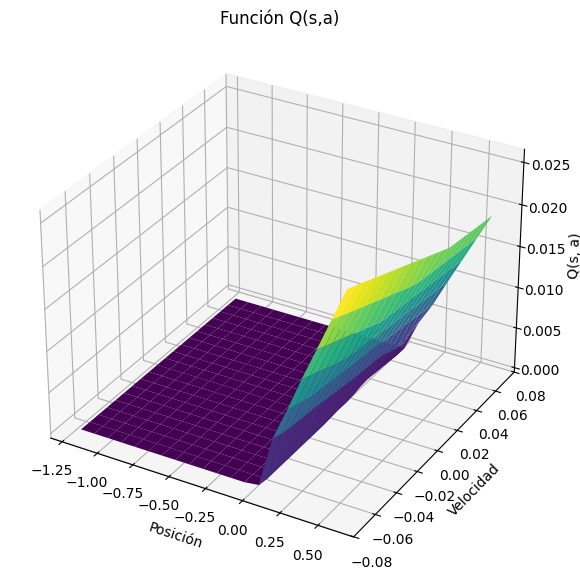

In [56]:
from mpl_toolkits.mplot3d import Axes3D

#print(sarsa_solucion_4.model.input_shape)
#print(observation)

# malla de posición y velocidad
pos_range = np.linspace(-1.2, 0.6, 20)
vel_range = np.linspace(-0.07, 0.07, 20)
pos_grid, vel_grid = np.meshgrid(pos_range, vel_range)


Q_values = np.zeros_like(pos_grid)

for i in range(pos_grid.shape[0]):
    for j in range(pos_grid.shape[1]):
        state = np.array([[pos_grid[i, j], vel_grid[i, j]]])  # (1, 2)
        state = np.expand_dims(state, axis=1)  # (1, 1, 2)
        q_values = sarsa_solucion_1.model.predict(state)
        Q_values[i, j] = np.max(q_values)  # Tomar la mejor acción (greedy)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(pos_grid, vel_grid, Q_values, cmap='viridis')
ax.set_xlabel('Posición')
ax.set_ylabel('Velocidad')
ax.set_zlabel('Q(s, a)')
ax.set_title('Función Q(s,a)')

plt.show()

# Reflexiones Finales



# Referencias

[1] Sutton, R. S. and Barto, A. G. (2018). Reinforcement Learning: An Introduction. The MIT Press, second edition.

[2]

[3] Gym Documentation, Mountain Car. `https://gymnasium.farama.org/environments/classic_control/mountain_car/`


[4] keras-rl2 Documentation, SARSA. `https://github.com/inarikami/keras-rl2/blob/master/rl/agents/sarsa.py`